In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Set plot style
plt.rcParams['figure.figsize'] = (10, 6)

Cell 1: Imports successful.


In [ ]:
# Load the data
df = pd.read_csv('../data/raw/data.csv')

# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
TARGET_COL = 'fatigue'

# Define Features (X as DataFrame) and Target (y as Series)
X = df.drop(TARGET_COL, axis=1)
y = df[TARGET_COL]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()

# --- FIX: Keep the scaled data as NumPy arrays for model training ---
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print("Data prepared and split.")
print("X_train_scaled is a:", type(X_train_scaled))
print("y_train is a:", type(y_train))
print("Shape of X_train_scaled:", X_train_scaled.shape)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!! CRITICAL ERROR !!!!!!!!!!!!!!!!!!!!!
The loaded dataset in 'data/raw/data.csv' is WRONG.
The required column 'fatigue_strength' was not found.
Detected columns are: ['sl._no.', 'nt', 'tht', 'tht', 'thqcr', 'ct', 'ct', 'dt', 'dt', 'qmt', 'tt', 'tt', 'tcr', 'c', 'si', 'mn', 'p', 's', 'ni', 'cr', 'cu', 'mo', 'redratio', 'da', 'db', 'dc', 'fatigue']
SOLUTION: Go to 'data/raw/', delete 'data.csv', and replace it
with the 'Steel Fatigue Strength Prediction' dataset.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


ValueError: Wrong dataset loaded. Please see the message above.

In [ ]:
models = {
    "RandomForest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBRegressor(random_state=42, n_jobs=-1),
    "LightGBM": lgb.LGBMRegressor(random_state=42, n_jobs=-1)
}

results = {}

for name, model in models.items():
    print(f"--- Training {name} ---")
    
    # Pass X_train_scaled (NumPy array) and y_train (Series/NumPy array)
    # y_train will be correctly interpreted by all libraries here.
    model.fit(X_train_scaled, y_train)
    
    # Predict using the scaled test data (NumPy array)
    y_pred = model.predict(X_test_scaled)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results[name] = {'R²': r2, 'MAE': mae, 'RMSE': rmse}
    print(f"R²: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}\n")

results_df = pd.DataFrame(results).T
print("--- Model Comparison ---")
display(results_df)

--- Training RandomForest ---
R²: 0.9694 | MAE: 22.5119 | RMSE: 35.5922

--- Training XGBoost ---
R²: 0.9878 | MAE: 16.0718 | RMSE: 22.4744

--- Training LightGBM ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 529
[LightGBM] [Info] Number of data points in the train set: 349, number of used features: 26
[LightGBM] [Info] Start training from score 552.538682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

c:\Users\Jai Dayanand\Downloads\Patient-chemist\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,R²,MAE,RMSE
RandomForest,0.969360,22.511932,35.592166
XGBoost,0.987783,16.071806,22.474391
LightGBM,0.970796,18.881250,34.748247


In [ ]:
print("--- Hyperparameter Tuning for RandomForestRegressor ---")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=kf,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

# Pass the NumPy array and Series directly
grid_search.fit(X_train_scaled, y_train)

print("\nBest Parameters found:")
print(grid_search.best_params_)

print(f"\nBest R² score from GridSearch: {grid_search.best_score_:.4f}")

best_rf_model = grid_search.best_estimator_

--- Hyperparameter Tuning for RandomForestRegressor ---
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters found:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Best R² score from GridSearch: 0.9647


In [ ]:
print("--- Evaluating the Tuned RandomForest Model on Test Set ---")
y_pred_tuned = best_rf_model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred_tuned)
mae = mean_absolute_error(y_test, y_pred_tuned)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

print(f"Tuned Model R²: {r2:.4f}")
print(f"Tuned Model MAE: {mae:.4f}")
print(f"Tuned Model RMSE: {rmse:.4f}")

--- Evaluating the Tuned RandomForest Model on Test Set ---
Tuned Model R²: 0.9719
Tuned Model MAE: 21.7391
Tuned Model RMSE: 34.1122


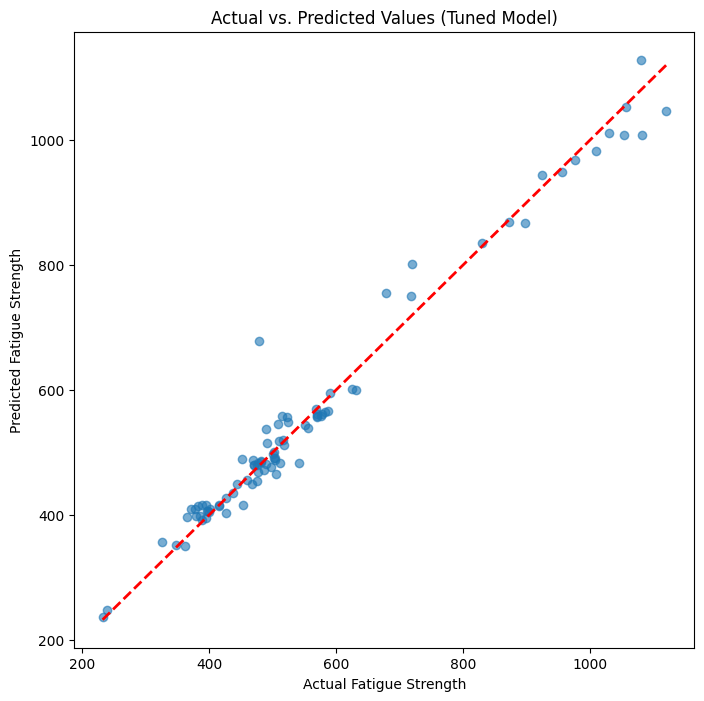

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_tuned, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Fatigue Strength')
plt.ylabel('Predicted Fatigue Strength')
plt.title('Actual vs. Predicted Values (Tuned Model)')
plt.show()

In [ ]:
# Create directories if they don't exist
os.makedirs('../models', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)

# Save the best model
model_path = '../models/model.pkl'
joblib.dump(best_rf_model, model_path)
print(f"Model saved to {model_path}")

# Save the scaler
scaler_path = '../data/processed/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

# --- Save the processed data with column headers for other scripts to use ---
# Get the column names from the original DataFrame before scaling
feature_names = X.columns

pd.DataFrame(X_train_scaled, columns=feature_names).to_csv('../data/processed/X_train.csv', index=False)
pd.DataFrame(X_test_scaled, columns=feature_names).to_csv('../data/processed/X_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False, header=True)
y_test.to_csv('../data/processed/y_test.csv', index=False, header=True)
print("\nProcessed data files (with headers) saved to '../data/processed/'")

Model saved to ../models/model.pkl
Scaler saved to ../data/processed/scaler.pkl

Processed data files (with headers) saved to '../data/processed/'
